# Use Case

In the financial markets investors are chasing higher returns, the funds specialized in this field are the quantitative hedge funds. In the Quantitative investing landscape there is a myriad of strategies, the one which is the focus of this report is the Neural Network model, with the type of model being a Recurring Neural Network (RNN). Under the RNN scope there are the LSTM algorithms that have recently been incorporated in various oil predicting algorithms and strategies because of their effectiveness compared to other neural algorithms.  
Making predictions in oil prices are in fact solving a time series prediction problem. For any algorithms to be able to have a reasonable effectiveness in predicting time series there must be a pattern in the time series, for example there can be a seasonality pattern in the time series or other forms of anomalies. If the time series data is completely random, there can not be a prediction made.
In this project, given a historical oil price, we whould like to predict to future oil price in 1 day/week/month that is the root question for investor. 


Data Set
-----------
U.S. Energy Information Administration, Crude Oil Prices: Brent - Europe [DCOILBRENTEU], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DCOILBRENTEU, January 10, 2018.

Data is daily, 10 years period from 2010/03/23 to 2020/03/23

In [4]:
import pandas as pd

df_data_1 = pd.read_csv("E:/Coursera/IBM Advan DS/Capstone project/DCOILBRENTEU_10y.csv")

# Data Quality Assessment
# Data Cleasing

In [6]:
df_data_1 = df_data_1[df_data_1.DCOILBRENTEU != "."]
print(df_data_1.shape)

(2535, 2)


In [8]:
df_data_1.head(5)

,DATE,DCOILBRENTEU
0,2010-03-23,79.17
1,2010-03-24,78.03
2,2010-03-25,78.64
3,2010-03-26,77.98
4,2010-03-29,79.89


# Data Exploration and Visualization

# Histograms<a id="8"></a>

A histogram is a way of representing the *frequency* distribution of numeric dataset. The way it works is it partitions the x-axis into *bins*, assigns each data point in our dataset to a bin, and then counts the number of data points that have been assigned to each bin. So the y-axis is the frequency or the number of data points in each bin. Note that we can change the bin size and usually one needs to tweak it so that the distribution is displayed nicely.

In [41]:
# np.histogram returns 2 values
import numpy as np
df_data_plot=df_data_1
df_data_plot['DCOILBRENTEU'] = pd.to_numeric(df_data_plot['DCOILBRENTEU'])

df_data_plot.dtypes


DATE             object
DCOILBRENTEU    float64
dtype: object

In [42]:
count, bin_edges = np.histogram(df_data_plot['DCOILBRENTEU'])

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins

[ 42 119 421 450 305 215  77 237 576  93]
[ 23.3    33.784  44.268  54.752  65.236  75.72   86.204  96.688 107.172
 117.656 128.14 ]


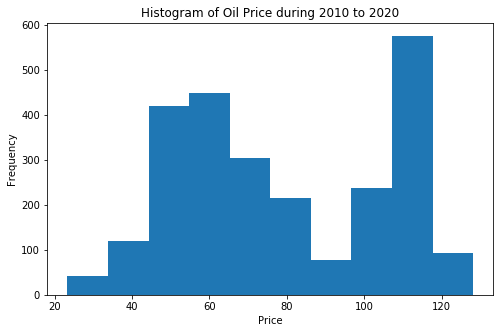

In [45]:
df_data_plot['DCOILBRENTEU'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Oil Price during 2010 to 2020') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('Price') # add x-label

plt.show()

# Box Plots 
A box plot is a way of statistically representing the distribution of the data through five main dimensions:

Minimun: Smallest number in the dataset.
First quartile: Middle number between the minimum and the median.
Second quartile (Median): Middle number of the (sorted) dataset.
Third quartile: Middle number between median and maximum.
Maximum: Highest number in the dataset.

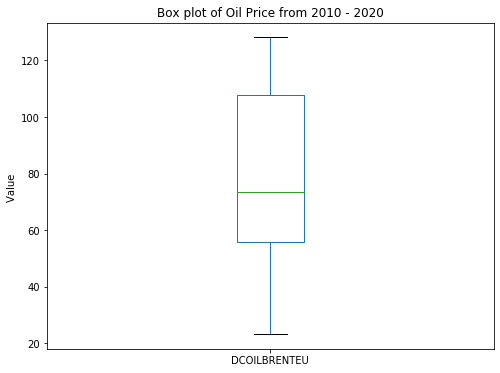

In [46]:
df_data_plot['DCOILBRENTEU'].plot(kind='box', figsize=(8, 6))

plt.title('Box plot of Oil Price from 2010 - 2020')
plt.ylabel('Value ')

plt.show()

We can immediately make a few key observations from the plot above:
1. The minimum number of immigrants is around 23 (min), maximum number is around 130 (max), and  median number of immigrants is around 73 (median).
2. 25% of the price of ~56 or fewer (First quartile).
3. 75% of the price of ~107 or fewer (Third quartile).
4. There is no outlier since our data source is reliable

We can view the actual numbers by calling the `describe()` method on the dataframe.

In [47]:
df_data_plot['DCOILBRENTEU'].describe(include="all")

count    2535.000000
mean       78.837254
std        26.402447
min        23.300000
25%        55.945000
50%        73.560000
75%       107.820000
max       128.140000
Name: DCOILBRENTEU, dtype: float64

Data visualization over time

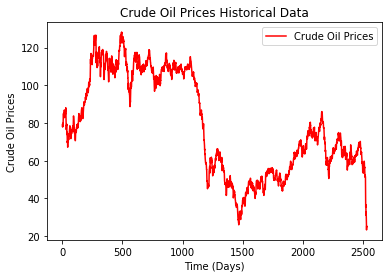

In [10]:
import matplotlib.pyplot as plt
df_data_1_plot = df_data_1.iloc[:,1:2].values.astype(float)
# Visualising the Data
plt.plot(df_data_1_plot, color = 'red', label = 'Crude Oil Prices')
plt.title('Crude Oil Prices Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

# Which Model to Use
There are several Deep learning model for time sereis prediction such as Convolutional Neural Networks (CNNs), Deep Belief Networks (DBNs), Long-Short Term Memory (LSTM). LSTM is pretty good at extracting patterns in input feature space, where the input data spans over long sequences. Given the gated architecture of LSTM's that has this ability to manipulate its memory state, they are ideal for such problems. We also choose LSTM for easy implementation. 

Stateful vs. Stateless LSTM
--------------------------

1. **Stateless**: LSTM updates parameters on **batch 1** and then initiates cell states (meaning - memory, usually with zeros) for **batch 2** 
2. **Stateful**: it uses batch 1 last output cell sates as initial states for batch 2.

When to use which?
----------------

- When  sequences in batches are related to each other (e.g. prices of one commodity), we should better use **stateful** mode
- Else, when one sequence represents a complete sentence, we  should go with **stateless** mode




Batch-size: which batch-size to choose?
------------------------------------
Batch size impacts to the prediction accuracy. We have tryied several batch size, then 
we select a batch size of 64.


In [21]:
#import packages
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import load_model

Using TensorFlow backend.


In [22]:
# defining the batch size and number of epochs
batch_size = 64
epochs = 120
timesteps = 30

Batch-size and trainings-set size
-------------------------------

With **stateful LSTMs** the trainings-set size must be divisible without remainder by the batch-size (modulo = 0)

In [23]:
length = len(df_data_1)
print(length)
length *= 1 - 0.1
print(length)


2535
2281.5


In [25]:
2281.5%64.0

41.5

In [26]:
1792.0%64.0

0.0

In [27]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))

In [28]:
length = get_train_length(df_data_1, batch_size, 0.1)
print(length)

2240
2240


In [29]:
#Adding timesteps * 2
upper_train = length + timesteps*2
df_data_1_train = df_data_1[0:upper_train]
training_set = df_data_1_train.iloc[:,1:2].values
training_set.shape

(2300, 1)

# Feature Engineering: Scaling
Because the data for the sequence prediction problem probably needs to be scaled when training a neural network, such as a Long Short-Term Memory recurrent neural network.
We will scale between 0 and 1.

In [30]:

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(2300, 1)

In [31]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print(length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print(len(X_train))
print(len(y_train))
#create X_train matrix
#30 items per array (timestep) 
print(X_train[0:2])
print(np.array(X_train).shape)
#create Y_train matrix
#30 items per array (timestep) 
print(y_train[0:2])
print(np.array(y_train).shape)

2270
2240
2240
[array([0.52051307, 0.50935083, 0.51532361, 0.50886126, 0.52756291,
       0.52335259, 0.5322628 , 0.55439146, 0.57250563, 0.57808675,
       0.57260354, 0.55439146, 0.55576226, 0.57965338, 0.56232253,
       0.58552825, 0.59620092, 0.57573681, 0.55889553, 0.57495349,
       0.57319103, 0.57348477, 0.58826985, 0.59443846, 0.58337413,
       0.57358269, 0.59541761, 0.589249  , 0.60785274, 0.58141584]), array([0.50935083, 0.51532361, 0.50886126, 0.52756291, 0.52335259,
       0.5322628 , 0.55439146, 0.57250563, 0.57808675, 0.57260354,
       0.55439146, 0.55576226, 0.57965338, 0.56232253, 0.58552825,
       0.59620092, 0.57573681, 0.55889553, 0.57495349, 0.57319103,
       0.57348477, 0.58826985, 0.59443846, 0.58337413, 0.57358269,
       0.59541761, 0.589249  , 0.60785274, 0.58141584, 0.5512582 ])]
(2240, 30)
[array([0.5512582 , 0.53069617, 0.49417409, 0.5098404 , 0.51884853,
       0.51591109, 0.52286302, 0.49368452, 0.46861843, 0.48085773,
       0.44893763, 0.42641731,

In [48]:
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)


(2240, 30, 1)
(2240, 30, 1)


# Which Framework to Use
Because Keras easy to learn and easy to use, our data is small and simple, thus we choose Kera to implement LSTM.

In [60]:
# Building the LSTM
# Importing the Keras libraries and packages

from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py

# Model Definition with MAE Loss-Function
 Initialising the LSTM Model with MAE Loss-Function
 
 Using Functional API

In [61]:


inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
#each layer is the input of the next layer
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

#adam is fast starting off and then gets slower and more precise
#mae -> mean absolute error loss function
regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_5 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_6 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_3 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [62]:


from keras import backend as K

K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))


In [63]:
# 1st LSTM Layer
parameters = 4 * 10 * (1 + 10 + 1)
print(parameters)

480


In [64]:
parameters = 4 * 10 * (10 + 10 + 1)
print(parameters)

840


# Model Training

In [65]:
#Statefull
for i in range(epochs):
    print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    #resets only the states but the weights, cell and hidden are kept.
    regressor_mae.reset_states()
    
#Stateless
#between the batches the cell and hidden states are lost.
#regressor_mae.fit(X_train, y_train, shuffle=False, epochs = epochs, batch_size = batch_size)

Epoch: 0
Epoch 1/1
2240/2240 [==============================] - 2s 741us/step - loss: 0.1219
Epoch: 1
Epoch 1/1
2240/2240 [==============================] - 1s 277us/step - loss: 0.0971
Epoch: 2
Epoch 1/1
2240/2240 [==============================] - 1s 285us/step - loss: 0.0948
Epoch: 3
Epoch 1/1
2240/2240 [==============================] - 1s 283us/step - loss: 0.0922
Epoch: 4
Epoch 1/1
2240/2240 [==============================] - 1s 290us/step - loss: 0.0906
Epoch: 5
Epoch 1/1
2240/2240 [==============================] - 1s 285us/step - loss: 0.0894
Epoch: 6
Epoch 1/1
2240/2240 [==============================] - 1s 281us/step - loss: 0.0875
Epoch: 7
Epoch 1/1
2240/2240 [==============================] - 1s 290us/step - loss: 0.0863
Epoch: 8
Epoch 1/1
2240/2240 [==============================] - 1s 285us/step - loss: 0.0856
Epoch: 9
Epoch 1/1
2240/2240 [==============================] - 1s 288us/step - loss: 0.0847
Epoch: 10
Epoch 1/1
2240/2240 [==============================] - 1s 27

2240/2240 [==============================] - 1s 398us/step - loss: 0.0696
Epoch: 88
Epoch 1/1
2240/2240 [==============================] - 1s 426us/step - loss: 0.0695
Epoch: 89
Epoch 1/1
2240/2240 [==============================] - 1s 399us/step - loss: 0.0694
Epoch: 90
Epoch 1/1
2240/2240 [==============================] - 1s 405us/step - loss: 0.0692
Epoch: 91
Epoch 1/1
2240/2240 [==============================] - 1s 375us/step - loss: 0.0691
Epoch: 92
Epoch 1/1
2240/2240 [==============================] - 1s 342us/step - loss: 0.0690
Epoch: 93
Epoch 1/1
2240/2240 [==============================] - 1s 308us/step - loss: 0.0689
Epoch: 94
Epoch 1/1
2240/2240 [==============================] - 1s 320us/step - loss: 0.0686
Epoch: 95
Epoch 1/1
2240/2240 [==============================] - 1s 329us/step - loss: 0.0686
Epoch: 96
Epoch 1/1
2240/2240 [==============================] - 1s 322us/step - loss: 0.0684
Epoch: 97
Epoch 1/1
2240/2240 [==============================] - 1s 323us/step -

# Save model

In [66]:

import h5py
regressor_mae.save(filepath="E:/Coursera/IBM Advan DS/Capstone project/my_10y_model_with_mae_30_ts.h5")

# Model Evaluation
Commonly used metrics to evaluate forecast accuracy are the coefficient of variation (CV RMSE),
the root mean squared error (RMSE) and the Mean Absolute Error (MAE). CV (RMSE) is the RMSE normalized by the mean of the measured values and quantifies typical size of the error relative to the mean of the observations. A high CV score indicates that a model has a high error range. Root Mean Square Error (RMSE) is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed. MAE, a commonly used
metric, is the mean value of the sum of absolute differences between actual and forecasted. RMSE is
another commonly used metric. It penalizes the larger error terms and tends to become increasingly
larger than MAE for outliers


In [67]:
#load model
import h5py
regressor_mae = load_model(filepath="E:/Coursera/IBM Advan DS/Capstone project/my_10y_model_with_mae_30_ts.h5")

In [68]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))

In [69]:
test_length = get_test_length(df_data_1, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

2364
2428
2428
128


In [70]:
print(upper_train, upper_test, len(df_data_1))

2300 2488 2535


In [71]:
# construct test set

#subsetting
df_data_1_test = df_data_1[upper_train:upper_test] 
test_set = df_data_1_test.iloc[:,1:2].values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [72]:
X_test.shape

(128, 30, 1)

In [73]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print(predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print(predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)

(128, 30, 1)
(128, 30)
(98, 1)


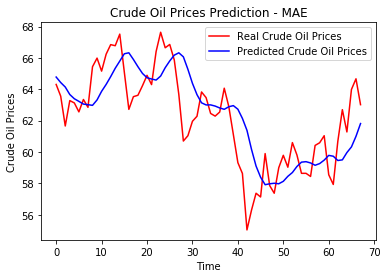

In [74]:
# Visualising the results
plt.plot(test_set[timesteps:len(y_test)].astype(float), color = 'red', label = 'Real Crude Oil Prices')
plt.plot(y_test[0:len(y_test) - timesteps].astype(float), color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [75]:
#MSE (mean sqared error)
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

2.0753383164298707


In [76]:
#MAE (mean absolut error)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

1.6341931690889244


# Model Definition with MSE Loss-Function
Initialising the LSTM Model with MSE Loss-Function

Using Functional API

In [77]:
# Initialising the LSTM Model with MSE Loss Function

inputs_1_mse = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mse = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mse)
lstm_2_mse = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mse)

output_1_mse = Dense(units = 1)(lstm_2_mse)

regressor_mse = Model(inputs=inputs_1_mse, outputs = output_1_mse)

#mse -> mean squared error as loss function
regressor_mse.compile(optimizer='adam', loss = 'mse')
regressor_mse.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_7 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_8 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_4 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [78]:


from keras import backend as K

K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))


# Model Training

In [79]:
epochs = 120
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mse.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mse.reset_states()

Epoch: 0
Epoch 1/1
2240/2240 [==============================] - 2s 761us/step - loss: 0.2527
Epoch: 1
Epoch 1/1
2240/2240 [==============================] - 1s 278us/step - loss: 0.0755
Epoch: 2
Epoch 1/1
2240/2240 [==============================] - 1s 275us/step - loss: 0.0228
Epoch: 3
Epoch 1/1
2240/2240 [==============================] - 1s 273us/step - loss: 0.0204
Epoch: 4
Epoch 1/1
2240/2240 [==============================] - 1s 273us/step - loss: 0.0168
Epoch: 5
Epoch 1/1
2240/2240 [==============================] - 1s 275us/step - loss: 0.0158
Epoch: 6
Epoch 1/1
2240/2240 [==============================] - 1s 275us/step - loss: 0.0154
Epoch: 7
Epoch 1/1
2240/2240 [==============================] - 1s 275us/step - loss: 0.0151
Epoch: 8
Epoch 1/1
2240/2240 [==============================] - 1s 282us/step - loss: 0.0147
Epoch: 9
Epoch 1/1
2240/2240 [==============================] - 1s 274us/step - loss: 0.0143
Epoch: 10
Epoch 1/1
2240/2240 [==============================] - 1s 27

2240/2240 [==============================] - 1s 333us/step - loss: 0.0089
Epoch: 88
Epoch 1/1
2240/2240 [==============================] - 1s 399us/step - loss: 0.0089
Epoch: 89
Epoch 1/1
2240/2240 [==============================] - 1s 331us/step - loss: 0.0088
Epoch: 90
Epoch 1/1
2240/2240 [==============================] - 1s 321us/step - loss: 0.0088
Epoch: 91
Epoch 1/1
2240/2240 [==============================] - 1s 325us/step - loss: 0.0088
Epoch: 92
Epoch 1/1
2240/2240 [==============================] - 1s 337us/step - loss: 0.0088
Epoch: 93
Epoch 1/1
2240/2240 [==============================] - 1s 330us/step - loss: 0.0087
Epoch: 94
Epoch 1/1
2240/2240 [==============================] - 1s 340us/step - loss: 0.0087
Epoch: 95
Epoch 1/1
2240/2240 [==============================] - 1s 351us/step - loss: 0.0087
Epoch: 96
Epoch 1/1
2240/2240 [==============================] - 1s 343us/step - loss: 0.0087
Epoch: 97
Epoch 1/1
2240/2240 [==============================] - 1s 363us/step -

# Save Model

In [80]:
import h5py
regressor_mse.save(filepath="E:/Coursera/IBM Advan DS/Capstone project/my_10yearmodel_with_mse_30_ts.h5")

# Model Evaluation

In [81]:
regressor_mse = load_model(filepath="E:/Coursera/IBM Advan DS/Capstone project/my_10yearmodel_with_mse_30_ts.h5")

In [82]:
predicted_bcg_values_test_mse = regressor_mse.predict(X_test, batch_size=batch_size)
regressor_mse.reset_states()

predicted_bcg_values_test_mse = np.reshape(predicted_bcg_values_test_mse, 
                                       (predicted_bcg_values_test_mse.shape[0], 
                                        predicted_bcg_values_test_mse.shape[1]))
predicted_bcg_values_test_mse = sc.inverse_transform(predicted_bcg_values_test_mse)

pred_mse = []

for j in range(0, testset_length - timesteps):
    pred_mse = np.append(pred_mse, predicted_bcg_values_test_mse[j, timesteps-1])

pred_mse = np.reshape(pred_mse, (pred_mse.shape[0], 1))

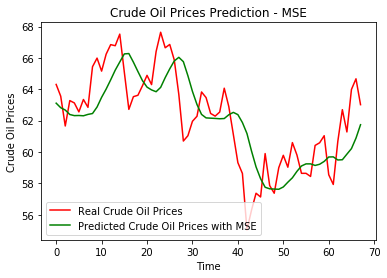

In [83]:
# Visualising the results
plt.plot(test_set[timesteps:len(pred_mse)].astype(float), color = 'red', label = 'Real Crude Oil Prices')
plt.plot(pred_mse[0:len(pred_mse) - timesteps], color = 'green', label = 'Predicted Crude Oil Prices with MSE')
plt.title('Crude Oil Prices Prediction - MSE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [84]:
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps]))
print(rmse)

2.0983585111473055


# Model Comparison
Commonly used metrics to evaluate forecast accuracy are the coefficient of variation (CV RMSE),
the root mean squared error (RMSE) and the Mean Absolute Error (MAE). In order to compare between MSE and MAE model, we normalize RSME and MEA by the mean of the measured values and quantifies typical size of the error relative to the mean of the observations (e.g, mean, median, Thirst quartile - First quartile). A high CV score indicates that a model has a high error range.

In [85]:
mean = np.mean(np.float64(test_set[timesteps:len(pred_mse)]))
print(mean)

62.21411764705883


In [86]:
rmse/mean * 100

3.372801207358288

In [87]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps])
print(mae)

1.7032454591638901


In [88]:
mae/mean * 100

2.737715366834285

We can conclude that MEA loss function have better performance since mea/mean is less than rmse/mean.